In [1]:
basepath = 'C:/Users/shaur/Desktop/UTD/ANLP'

In [2]:
import sys
from pathlib import Path

In [3]:
base_folder = Path(basepath)
data_folder = base_folder/'datasets/emotion'
model_folder = base_folder/'models/nlp_spring_2024/emotion/nn'
custom_functions = base_folder/'custom_files'

In [4]:
sys.path.append(str(custom_functions))
model_folder.mkdir(exist_ok=True, parents = True)

In [5]:
import torch
import torch.nn as nn

# For working with textual data vocabularies and for displaying model summaries
from torchtext.vocab import vocab

# General-purpose Python libraries for random number generation and numerical operations
import random
import numpy as np

# Utilities for efficient serialization/deserialization of Python objects and for element tallying
import joblib
from collections import Counter
import re

# For creating lightweight attribute classes and for partial function application
from functools import partial

# For filesystem path handling, generating and displaying confusion matrices, and date-time manipulations
from sklearn.metrics import multilabel_confusion_matrix, hamming_loss, accuracy_score, f1_score
from sklearn.model_selection import train_test_split
from datetime import datetime
import pandas as pd
import emoji
import string

# For plotting and visualization
import matplotlib.pyplot as plt
import seaborn as sns

from kaggle import api

### NEW ##########################
# imports from Huggingface ecosystem
import evaluate
from datasets import load_dataset, DatasetDict, Dataset
from transformers import TrainingArguments, Trainer
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from transformers import AutoConfig
from transformers import pipeline
import wandb

c:\Users\shaur\anaconda3\envs\anlp\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
train = pd.read_csv(data_folder/'train.csv')
test = pd.read_csv(data_folder/'test.csv')

In [7]:
train.drop(columns=['ID'], inplace=True)
train.head()

,Tweet,anger,anticipation,disgust,fear,joy,love,optimism,pessimism,sadness,surprise,trust
0,“Worry is a down payment on a problem you may ...,0,1,0,0,0,0,1,0,0,0,1
1,Whatever you decide to do make sure it makes y...,0,0,0,0,1,1,1,0,0,0,0
2,@Max_Kellerman it also helps that the majorit...,1,0,1,0,1,0,1,0,0,0,0
3,Accept the challenges so that you can literall...,0,0,0,0,1,0,1,0,0,0,0
4,My roommate: it's okay that we can't spell bec...,1,0,1,0,0,0,0,0,0,0,0


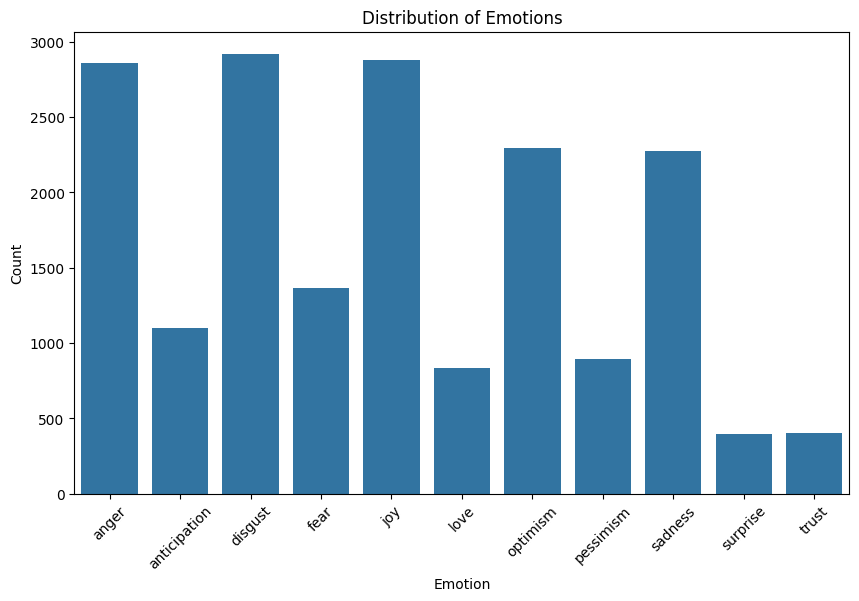

In [8]:
emotion_counts = train.drop(columns=['Tweet']).sum()
plt.figure(figsize=(10, 6))
sns.barplot(x=emotion_counts.index, y=emotion_counts.values)
plt.title('Distribution of Emotions')
plt.xlabel('Emotion')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

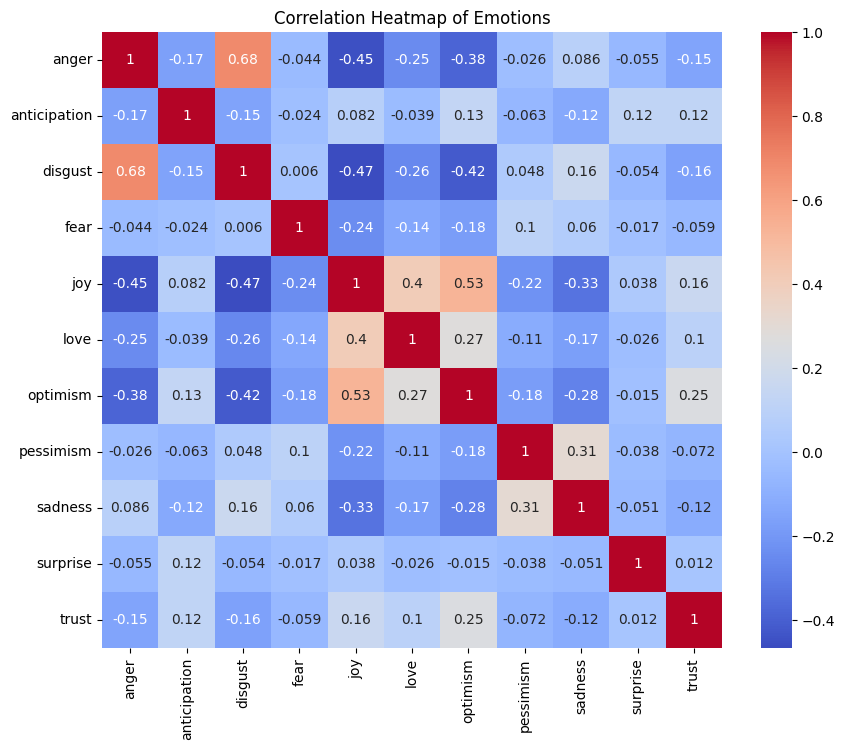

In [9]:
plt.figure(figsize=(10, 8))
sns.heatmap(train.drop(columns=['Tweet']).corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap of Emotions')
plt.show()

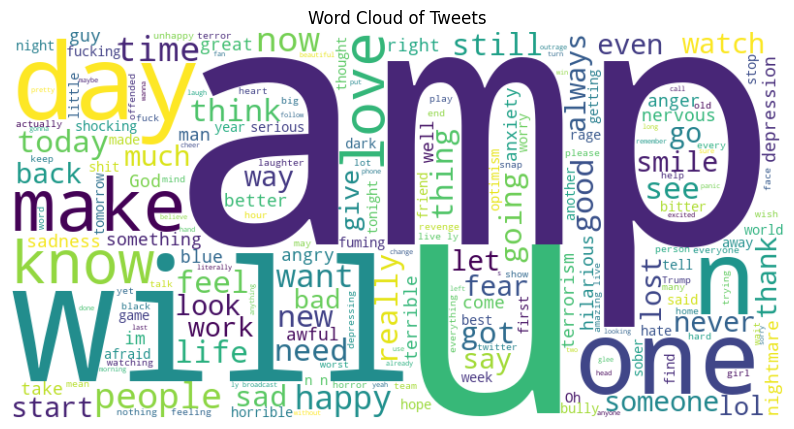

In [10]:
from wordcloud import WordCloud

tweet_text = ' '.join(train['Tweet'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(tweet_text)
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Word Cloud of Tweets')
plt.axis('off')
plt.show()

In [11]:
df = train.copy()

count    7724.000000
mean       95.092310
std        36.621615
min         6.000000
25%        64.000000
50%       100.000000
75%       131.000000
max       160.000000
Name: Tweet_Length, dtype: float64


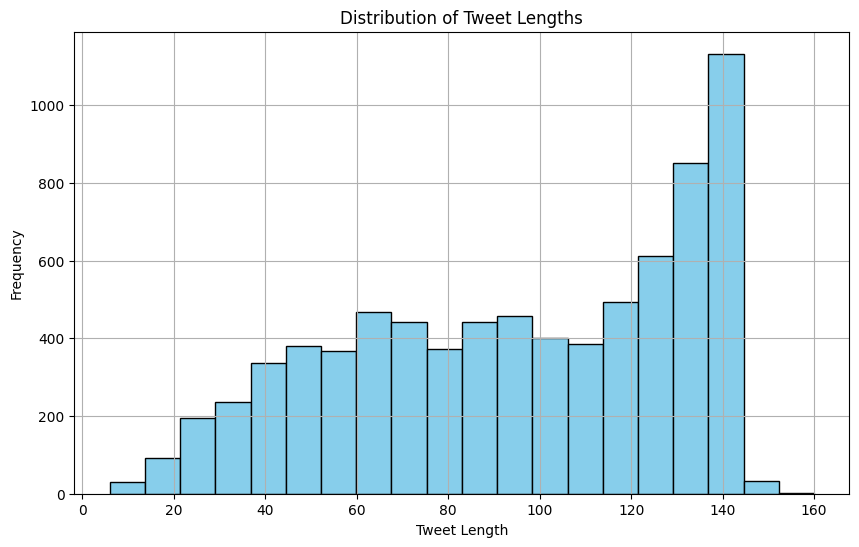

In [12]:
df['Tweet_Length'] = df['Tweet'].apply(lambda x: len(x))

# Summary statistics
print(df['Tweet_Length'].describe())

# Histogram of tweet lengths
plt.figure(figsize=(10, 6))
plt.hist(df['Tweet_Length'], bins=20, color='skyblue', edgecolor='black')
plt.title('Distribution of Tweet Lengths')
plt.xlabel('Tweet Length')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

## Preprocessing

In [13]:
def get_emoji_regexp():
    emojis = sorted(emoji.EMOJI_DATA, key=len, reverse=True)
    pattern = u'(' + u'|'.join(re.escape(u) for u in emojis) + u')'
    return re.compile(pattern)

def strip_emoji(text):
    return re.sub(get_emoji_regexp(), r"", text)

def strip_all_entities(text): 
    text = text.replace('\r', '').replace('\n', ' ').replace('\n', ' ').lower()
    text = re.sub(r"(?:\@|https?\://)\S+", "", text) #remove links and mentions
    text = re.sub(r'[^\x00-\x7f]',r'', text) #remove non utf8/ascii characters such as '\x9a\x91\x97\x9a\x97'
    banned_list= string.punctuation + 'Ã'+'±'+'ã'+'¼'+'â'+'»'+'§'
    table = str.maketrans('', '', banned_list)
    text = text.translate(table)
    return text

def clean_hashtags(tweet):
    new_tweet = " ".join(word.strip() for word in re.split('#(?!(?:hashtag)\b)[\w-]+(?=(?:\s+#[\w-]+)*\s*$)', tweet)) #remove last hashtags
    new_tweet2 = " ".join(word.strip() for word in re.split('#|_', new_tweet)) #remove hashtags symbol from words in the middle of the sentence
    return new_tweet2

#Filter special characters such as & and $ present in some words
def filter_chars(a):
    sent = []
    for word in a.split(' '):
        if ('$' in word) | ('&' in word):
            sent.append('')
        else:
            sent.append(word)
    return ' '.join(sent)

def remove_mult_spaces(text): # remove multiple spaces
    return re.sub("\s\s+" , " ", text)

In [14]:
train_clean = train['Tweet'].apply(strip_emoji).apply(strip_all_entities).apply(clean_hashtags).apply(filter_chars).apply(remove_mult_spaces)
train['Tweet'] = train_clean

In [15]:
X = train['Tweet'].values
y = train.loc[:, train.columns != 'Tweet'].values
y = np.array(y, dtype=float)

In [16]:
X_train, X_val, y_train, y_val  = train_test_split(X, y, random_state=42,test_size=0.1)

In [17]:
trainset = Dataset.from_dict({
    'texts': X_train,
    'labels': y_train
})
validset = Dataset.from_dict({
    'texts': X_val,
    'labels': y_val
})

In [18]:
id2label = {0: "anger", 1: "anticipation", 2: "disgust", 3: "fear", 4: "joy", 5: "love", 6: "optimism", 7: "pessimism", 8: "sadness", 9: "surprise", 10: "trust"}
label2id = {id2label[k]: k for k in id2label}

In [19]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = nn.functional.sigmoid(torch.Tensor(logits))
    predictions = (predictions >= 0.5).int().numpy()

    overall_accuracy = accuracy_score(labels, predictions)
    overall_f1 = f1_score(labels, predictions, average='macro', zero_division=0)

    return {
        'eval_accuracy': overall_accuracy,
        'eval_f1': overall_f1
    }

In [20]:
checkpoint = "roberta-base"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

In [21]:
def tokenize_fn(batch):
    return tokenizer(text = batch["texts"], truncation=True)

In [55]:
trainset_tokenized = trainset.map(tokenize_fn, batched=True)
validset_tokenized = validset.map(tokenize_fn, batched=True)
trainset_tokenized = trainset_tokenized.remove_columns(['texts'])
validset_tokenized = validset_tokenized.remove_columns(['texts'])
trainset_tokenized.set_format(type='torch')
validset_tokenized.set_format(type='torch')

Map: 100%|██████████| 773/773 [00:00<00:00, 22251.48 examples/s]


In [56]:
model = AutoModelForSequenceClassification.from_pretrained(
    checkpoint, 
    problem_type="multi_label_classification", 
    num_labels=len(label2id),
    id2label=id2label,
    label2id=label2id
)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [57]:
training_args = TrainingArguments(
    num_train_epochs=2,

    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    # weight_decay=0.01,  
    # learning_rate=2e-5, 
    optim='adamw_torch',

    # Checkpoint saving and model evaluation settings
    output_dir=str(model_folder/'bert'), 
    evaluation_strategy='steps', 
    eval_steps=100, 
    save_strategy="steps", 
    save_steps=100, 
    load_best_model_at_end=True, 
    save_total_limit=2, 
    metric_for_best_model="loss",
    greater_is_better=False, 
)

In [58]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=trainset_tokenized,
    eval_dataset=validset_tokenized,
    compute_metrics=compute_metrics,
    tokenizer=tokenizer,
)

trainer.train()

c:\Users\shaur\anaconda3\envs\anlp\lib\site-packages\accelerate\accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: shauryat1298 (shauryat12). Use `wandb login --relogin` to force relogin


                                                 
 11%|█▏        | 100/870 [01:05<07:52,  1.63it/s]

{'eval_accuracy': 0.16688227684346701, 'eval_f1': 0.2731278403135248, 'eval_loss': 0.3820047378540039, 'eval_runtime': 4.355, 'eval_samples_per_second': 177.496, 'eval_steps_per_second': 11.251, 'epoch': 0.23}


                                                 
 23%|██▎       | 200/870 [02:12<06:46,  1.65it/s]

{'eval_accuracy': 0.2069857697283312, 'eval_f1': 0.3675512470897397, 'eval_loss': 0.3485088348388672, 'eval_runtime': 4.3333, 'eval_samples_per_second': 178.388, 'eval_steps_per_second': 11.308, 'epoch': 0.46}


                                                 
 34%|███▍      | 300/870 [03:19<05:43,  1.66it/s]

{'eval_accuracy': 0.2755498059508409, 'eval_f1': 0.4568418346480075, 'eval_loss': 0.32908669114112854, 'eval_runtime': 4.3603, 'eval_samples_per_second': 177.281, 'eval_steps_per_second': 11.238, 'epoch': 0.69}


                                                 
 46%|████▌     | 400/870 [04:25<04:47,  1.64it/s]

{'eval_accuracy': 0.22897800776196636, 'eval_f1': 0.42287306534426977, 'eval_loss': 0.3202968239784241, 'eval_runtime': 4.3606, 'eval_samples_per_second': 177.268, 'eval_steps_per_second': 11.237, 'epoch': 0.92}


 57%|█████▋    | 500/870 [05:28<03:46,  1.63it/s]

{'loss': 0.3579, 'grad_norm': 1.7333825826644897, 'learning_rate': 2.1264367816091954e-05, 'epoch': 1.15}


                                                 
 57%|█████▋    | 500/870 [05:32<03:46,  1.63it/s]

{'eval_accuracy': 0.2522639068564036, 'eval_f1': 0.5088785085622981, 'eval_loss': 0.3157041072845459, 'eval_runtime': 4.0059, 'eval_samples_per_second': 192.963, 'eval_steps_per_second': 12.232, 'epoch': 1.15}


                                                 
 69%|██████▉   | 600/870 [06:40<02:44,  1.64it/s]

{'eval_accuracy': 0.2574385510996119, 'eval_f1': 0.5060141559831628, 'eval_loss': 0.3113979399204254, 'eval_runtime': 4.3924, 'eval_samples_per_second': 175.986, 'eval_steps_per_second': 11.156, 'epoch': 1.38}


                                                 
 80%|████████  | 700/870 [07:47<01:48,  1.57it/s]

{'eval_accuracy': 0.2690815006468305, 'eval_f1': 0.5212207198385389, 'eval_loss': 0.30770549178123474, 'eval_runtime': 4.3809, 'eval_samples_per_second': 176.446, 'eval_steps_per_second': 11.185, 'epoch': 1.61}


                                                 
 92%|█████████▏| 800/870 [08:54<00:42,  1.63it/s]

{'eval_accuracy': 0.2729624838292367, 'eval_f1': 0.5087025867583294, 'eval_loss': 0.3066633641719818, 'eval_runtime': 4.349, 'eval_samples_per_second': 177.741, 'eval_steps_per_second': 11.267, 'epoch': 1.84}


100%|██████████| 870/870 [09:39<00:00,  1.50it/s]

{'train_runtime': 587.198, 'train_samples_per_second': 23.675, 'train_steps_per_second': 1.482, 'train_loss': 0.3259412217414242, 'epoch': 2.0}


TrainOutput(global_step=870, training_loss=0.3259412217414242, metrics={'train_runtime': 587.198, 'train_samples_per_second': 23.675, 'train_steps_per_second': 1.482, 'train_loss': 0.3259412217414242, 'epoch': 2.0})

In [59]:
trainer.evaluate(trainset_tokenized)

100%|██████████| 435/435 [00:35<00:00, 12.41it/s]


{'eval_accuracy': 0.3344842468709538,
 'eval_f1': 0.5539021459020809,
 'eval_loss': 0.2510374188423157,
 'eval_runtime': 35.1273,
 'eval_samples_per_second': 197.88,
 'eval_steps_per_second': 12.384,
 'epoch': 2.0}

In [60]:
trainer.evaluate(validset_tokenized)

100%|██████████| 49/49 [00:03<00:00, 12.63it/s]


{'eval_accuracy': 0.2729624838292367,
 'eval_f1': 0.5087025867583294,
 'eval_loss': 0.3066633641719818,
 'eval_runtime': 3.9519,
 'eval_samples_per_second': 195.602,
 'eval_steps_per_second': 12.399,
 'epoch': 2.0}

# Evaluate

In [22]:
best_model_checkpoint_step = 800
print(f"The best model was saved at step {best_model_checkpoint_step}.")

model_checkpoint = model_folder/'bert'/f'checkpoint-{best_model_checkpoint_step}'
model = AutoModelForSequenceClassification.from_pretrained(
    model_checkpoint
)
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

The best model was saved at step 800.


In [23]:
checkpoint = str(model_folder/'bert'/f'checkpoint-{best_model_checkpoint_step}')
custom_pipeline = pipeline(
    task="text-classification",
    model=checkpoint,
    tokenizer=checkpoint,
    device=torch.cuda.current_device(),
    top_k=None)

In [24]:
def test_thresholds(labels, preds, thresholds: list):
    cal_f1 = []
    for threshold in thresholds:

        pred_df = []

        for pred in preds:
            temp_ans = label2id.copy()
            for pred_label in pred:
                if pred_label['score']>threshold:
                    temp_ans[pred_label['label']] = 1.
                else: 
                    temp_ans[pred_label['label']] = 0.
            
            pred_df.append(list(temp_ans.values()))
        
        cal_f1.append(f1_score(labels, pred_df, average='macro', zero_division=0))

    plt.figure(figsize=(8, 6))
    plt.plot(thresholds, cal_f1, marker='o', linestyle='-')
    plt.title('F1 Score vs. Threshold')
    plt.xlabel('Threshold')
    plt.ylabel('F1 Score')
    plt.grid(True)
    plt.show()

    # Find the best threshold
    best_threshold = thresholds[cal_f1.index(max(cal_f1))]
    best_f1_score = max(cal_f1)

    print("Best Threshold:", best_threshold)
    print("Best F1 Score:", best_f1_score)


### Evaluate on Trainset

In [25]:
preds = custom_pipeline(trainset['texts'])

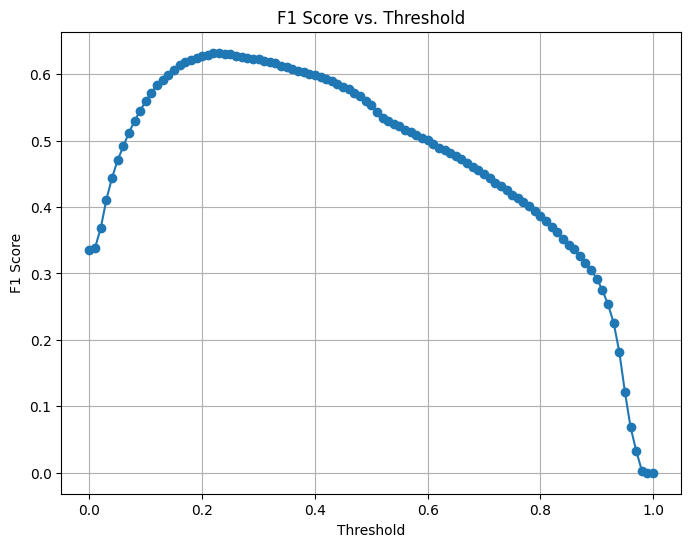

Best Threshold: 0.22
Best F1 Score: 0.632406173843899


In [26]:
thresholds = np.arange(0.0, 1.01, 0.01).tolist()
test_thresholds(trainset['labels'], preds, thresholds)

### Evaluate on Valset

In [27]:
preds = custom_pipeline(validset['texts'])

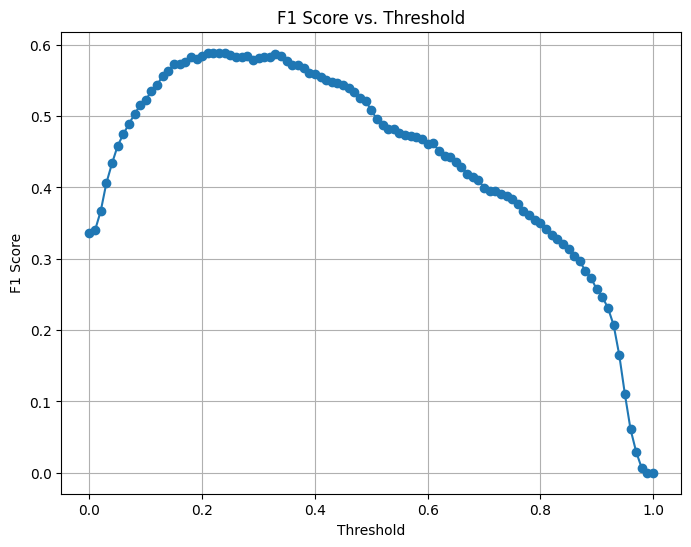

Best Threshold: 0.22
Best F1 Score: 0.5888933239657553


In [28]:
thresholds = np.arange(0.0, 1.01, 0.01).tolist()
test_thresholds(validset['labels'], preds, thresholds)

# Submission to Kaggle using Testset

In [29]:
X_test = test['Tweet']

In [30]:
X_test_cleaned = X_test.apply(strip_emoji).apply(strip_all_entities).apply(clean_hashtags).apply(filter_chars).apply(remove_mult_spaces).values

In [31]:
testset = Dataset.from_dict({
    'texts': X_test_cleaned,
})

In [32]:
preds = custom_pipeline(testset['texts'])

In [33]:
pred_df = pd.DataFrame(columns=test.columns[2:])

for pred in preds:
    temp_ans = label2id
    for pred_label in pred:
        if pred_label['score']>0.22:
            temp_ans[pred_label['label']] = 1
        else: 
            temp_ans[pred_label['label']] = 0
    pred_df = pd.concat([pred_df, pd.DataFrame([temp_ans])], ignore_index=True)

In [34]:
sub_df = pd.concat([test[['ID']], pred_df], axis=1)
sub_df.to_csv(model_folder/'first_sub.csv', index = False)

In [35]:
comp = 'emotion-detection-spring2014'
api.competition_submit(model_folder/'first_sub.csv', 'roberta', comp)

100%|██████████| 108k/108k [00:01<00:00, 99.5kB/s] 


Successfully submitted to Emotion Detection Spring2024